# Regression and Other Stories: Poisson Example

Demonstrate Poisson regression. See Chapter 15 in Regression and Other Stories.

---

### Load packages

In [1]:
using Random, Turing, Distributions, DataFrames, StatsPlots, Logging

Set random seed for reproducibility

In [2]:
Random.seed!(3579);

## Simulate fake data

In [3]:
n = 100
x = rand(Uniform(-2, 2), n)
a = 1 
b = 2
linpred = a .+ b * x
y = rand.(Poisson.(exp.(linpred)))
fake = DataFrame(Dict(
    :x=>x,
    :y=>y,
))
first(fake, 6)

,x,y
,Float64,Int64
1,0.735718,13
2,1.41794,42
3,-1.88818,0
4,0.873738,14
5,1.41079,46
6,0.850918,15


## Poisson regression

### Fit Poisson regression model

In [4]:
@model function PoissonRegression(x,y)

    α ~ TruncatedNormal(0, 5, 0, 10)
    β ~ Normal(0, 5)
    μ = α .+ β * x
    for i in 1:length(y)
        y[i] ~ Poisson(exp(μ[i]))
    end
end;

In [5]:
model_poisson = PoissonRegression(fake.x, fake.y)
fit_fake = sample(model_poisson, NUTS(0.50), 5000)
summarystats(fit_fake)

┌ Info: Found initial step size
│   ϵ = 0.0125
└ @ Turing.Inference /Users/tburch/.julia/packages/Turing/uAz5c/src/inference/hmc.jl:195
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/tburch/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:01


Summary Statistics
  parameters      mean       std   naive_se      mcse        ess      rhat 
      Symbol   Float64   Float64    Float64   Float64    Float64   Float64 

           α    0.8482    0.0820     0.0012    0.0052   209.5179    1.0013
           β    2.1054    0.0535     0.0008    0.0034   209.7295    1.0015


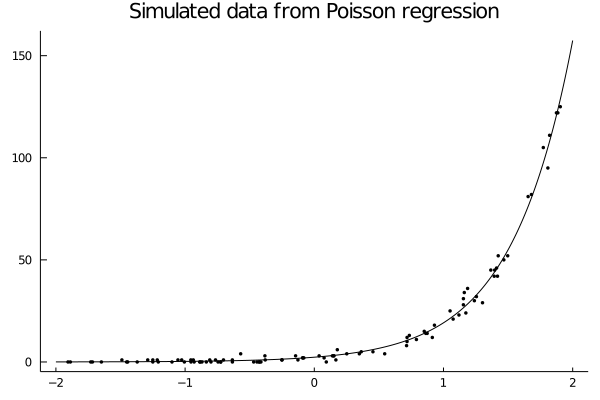

In [6]:
scatter(
    x,y,
    legend=false,
    color=:black,
    markersize=2,
    grid=false,
    title="Simulated data from Poisson regression"
)

x_samp = -2:0.01:2
params = get(fit_fake, [:α, :β])
y_samp = mean(params.α) .+ mean(params.β) * x_samp
plot!(x_samp, exp.(y_samp), color=:black)

## Overdispersion

The original notebook calls `rnegbin` which uses the μ and θ formulation of the negative binomial distribution, where `Distributions.jl` uses the r and p formulation.

In [7]:
function NegativeBinomial_MeanForm(μ, ϕ)
    p = 1 / (1 + μ / ϕ)
    r = ϕ
    return NegativeBinomial(r,p)
end;

In [8]:
@model function NegativeBinomialRegression(x,y)
    
    # Need a range for ϕ that covers 0.1, 1.0, and 10.0
    # Could probably get better estimates with a better prior for each instance
    ϕ ~ Uniform(0.0, 11.0) 

    α ~ TruncatedNormal(0, 5, 0, 10)
    β ~ Normal(0, 5)
    μ = α .+ β * x

    for i in 1:length(y)
        y[i] ~ NegativeBinomial_MeanForm(exp(μ[i]), ϕ)
    end
end;

In [9]:
phi_grid = [0.1, 1.0, 10.0]
K = length(phi_grid)
y_nb = fill(NaN, (K,n))
fake_nb = [DataFrame() for _ in 1:K]
model_nb =[]
fit_nb = []

# Disable logging for this, otherwise warnings hide our outcomes
stream = IOBuffer(UInt8[])
logger = Logging.SimpleLogger(stream, Logging.Error)
chain = Logging.with_logger(logger) do
    for k in 1:K
        y_nb[k,:] = rand.(NegativeBinomial_MeanForm.(exp.(linpred), phi_grid[k]))
        fake_nb[k] = DataFrame(Dict(
            :x=>x,
            :y=>y_nb[k,:],
        ))
        model_nb_i = NegativeBinomialRegression(fake_nb[k].x, fake_nb[k].y)
        fit_nb_i = sample(model_nb_i, NUTS(0.50), 5000)
        push!(model_nb, model_nb_i)
        push!(fit_nb, fit_nb_i)
        display(summarystats(fit_nb_i))
    end
end

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:01


Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat 
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64 

           α    0.5215    0.3370     0.0048    0.0062   1978.4892    0.9999
           β    2.5108    0.3571     0.0050    0.0091   1830.5058    0.9998
           ϕ    0.1087    0.0270     0.0004    0.0005   2776.8227    0.9999


Sampling: 100%|█████████████████████████████████████████| Time: 0:00:01


Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat 
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64 

           α    1.1234    0.1416     0.0020    0.0028   2851.2297    0.9998
           β    1.9852    0.1341     0.0019    0.0029   2658.5987    0.9998
           ϕ    1.1410    0.2161     0.0031    0.0036   2701.4806    0.9998


Sampling: 100%|█████████████████████████████████████████| Time: 0:00:01


Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat 
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64 

           α    0.8354    0.1091     0.0015    0.0026   1976.9938    0.9998
           β    2.1523    0.0891     0.0013    0.0019   1925.7990    0.9999
           ϕ    7.3445    1.6561     0.0234    0.0456   1111.5279    0.9998


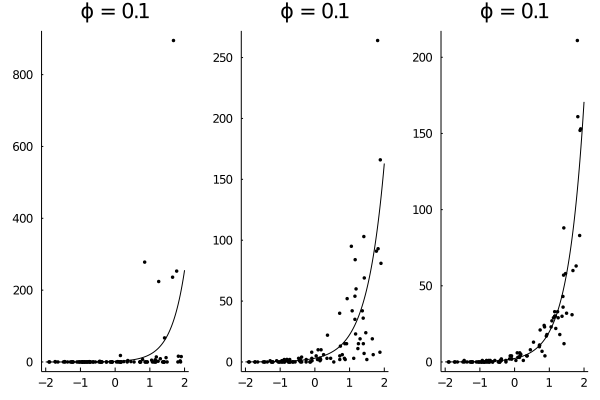

In [10]:
p =  plot( layout=(1,3))
for k in 1:K
    scatter!(
        p[k],
        x,y_nb[k,:],
        legend=false,
        color=:black,
        markersize=2,
        grid=false,
        title=string("ϕ = ", phi_grid[1])
    )
    x_samp = -2:0.01:2
    params = get(fit_nb[k], [:α, :β])
    y_samp = mean(params.α) .+ mean(params.β) * x_samp
    plot!(p[k],x_samp, exp.(y_samp), color=:black)
end
plot(p)